In [30]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict

In [31]:
## Create PINN, following from tensorflow example

class PINN(nn.Module):
    def __init__(
            self,
            N_input,
            N_hidden_arr,
            N_output,
            activation = nn.Tanh
    ):
        super(PINN, self).__init__()  # Create PINN object

        # Create input layer w/ activation function
        layers = [('Input', nn.Linear(N_input, N_hidden_arr[0]))]
        layers.append(('Input activation', activation()))

        # Create hidden layers
        for i in range(len(N_hidden_arr)-1):
            layers.append(
                ("Hidden %d" % (i+1), nn.Linear(N_hidden_arr[i], N_hidden_arr[i+1]))
            )
            layers.append(('Hidden activation %d' % (i+1), activation()))
        layers.append(('Output', nn.Linear(N_hidden_arr[-1], N_output)))
        layerdict = OrderedDict(layers)
        self.layers = nn.Sequential(layerdict)

    
    def forward(self, x):
        y = self.layers(x)
        return y

In [32]:
test = PINN(2, [32,16,16,32], 2)
print(test.layers)

Sequential(
  (Input): Linear(in_features=2, out_features=32, bias=True)
  (Input activation): Tanh()
  (Hidden 1): Linear(in_features=32, out_features=16, bias=True)
  (Hidden activation 1): Tanh()
  (Hidden 2): Linear(in_features=16, out_features=16, bias=True)
  (Hidden activation 2): Tanh()
  (Hidden 3): Linear(in_features=16, out_features=32, bias=True)
  (Hidden activation 3): Tanh()
  (Output): Linear(in_features=32, out_features=2, bias=True)
)


In [33]:
## constant values
u0 = 1  # defining velocity, density, and viscocity for fluid
rho0 = 1
nu0 = 0.01

torch.Size([84, 2])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
torch.Size([84, 2])


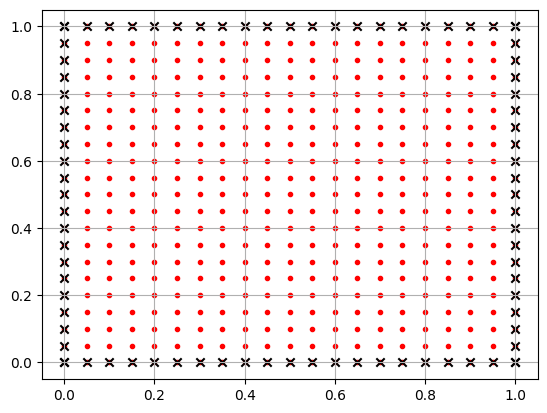

In [34]:
## Generate data, plot for sake of testing

# Create domain for collocation points
d = 0.05
x = torch.arange(0, 1+d, d)
y = torch.arange(0, 1+d, d)

# Collocation tensor
X = torch.stack(torch.meshgrid(x, y)).reshape(2,-1).T

# Get boundary conditions
b_left = torch.stack(torch.meshgrid(x[0], y)).reshape(2,-1).T  # x = 0, y = var, left wall
b_right = torch.stack(torch.meshgrid(x[-1],y)).reshape(2,-1).T
b_bottom = torch.stack(torch.meshgrid(x, y[0])).reshape(2,-1).T
b_top = torch.stack(torch.meshgrid(x, y[-1])).reshape(2,-1).T

X_train = torch.cat([b_left, b_bottom, b_right, b_top])
print(X_train.size())

## Get solutions for each boundary condition
walls_Y = torch.zeros(b_left.size())

# Get BC for lid driven component
wall_lid = torch.zeros(b_top.size()[0], b_top.size()[1])
wall_lid[:,0] = u0
print(wall_lid)

train_Y = torch.cat([walls_Y, walls_Y, walls_Y, wall_lid])
print(train_Y.size())

# Try and plot for test
plt.figure()
plt.scatter(X[:,0].numpy(), X[:,1].numpy(), marker='.', c='r')
plt.scatter(b_left[:,0].numpy(), b_left[:,1].numpy(), marker='x', c='k')
plt.scatter(b_right[:,0].numpy(), b_right[:,1].numpy(), marker='x', c='k')
plt.scatter(b_top[:,0].numpy(), b_top[:,1].numpy(), marker='x', c='k')
plt.scatter(b_bottom[:,0].numpy(), b_bottom[:,1].numpy(), marker='x', c='k')
plt.grid()
plt.show()


In [35]:
# Testing input/output for model
test = PINN(
    N_input=2,
    N_hidden_arr=[32,16,16,32],
    N_output=2
)
 # output and input are the same size/dimensions, means things are mappable???


# Plan

In [ ]:
## create neural network

class Net:
    def __init__(self):
        # Create PINN, send off to device if CUDA is available
        device = torch.device("cpu")
        print("Using CPU")
        self.model = PINN(
            N_input=2,
            N_hidden_arr=[32,16,16,32],
            N_output = 2
        ).to(device)

        # Create data
        self.d = 0.05
        x = torch.arange(0, 1+d, d)
        y = torch.arange(0, 1+d, d)

        self.X = torch.stack(torch.meshgrid(x,y)).reshape(2,-1).T

        b_left = torch.stack(torch.meshgrid(x[0], y)).reshape(2,-1).T  # x = 0, y = var, left wall
        b_right = torch.stack(torch.meshgrid(x[-1],y)).reshape(2,-1).T
        b_bottom = torch.stack(torch.meshgrid(x, y[0])).reshape(2,-1).T
        b_top = torch.stack(torch.meshgrid(x, y[-1])).reshape(2,-1).T

        self.X_train = torch.cat([b_left, b_bottom, b_right, b_top])

        # Get wall velocities in form of [u,v]
        walls_Y = torch.zeros(b_left.size())

        # Get BC for lid driven component
        wall_lid = torch.zeros(b_top.size()[0], b_top.size()[1])
        wall_lid[:,0] = u0

        self.data_train = torch.cat([walls_Y, walls_Y, walls_Y, wall_lid])

        # Send data off to devices
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.data_train = self.data_train.to(device)
        self.X.requires_grad = True
        self.X_train.requires_grad = True


        self.criterion = nn.MSELoss()
        self.iter = 1

        # Set up optimiser for LBFGS
        self.optimiser = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=1.0,
            max_iter = 75*10**3,
            max_eval = 75*10**3,
            history_size=50,
            tolerance_change=1e-15,
            tolerance_grad=1e-15,
            line_search_fn="strong_wolfe"
        )

        self.adam = torch.optim.Adam(self.model.parameters())
    
    def loss_function(self):
        self.optimiser.zero_grad()
        self.adam.zero_grad()

        def get_gradient(output, input):
            return torch.autograd.grad(outputs=output, 
                                       inputs=input,
                                       grad_outputs=torch.ones_like(output),
                                       create_graph=True,
                                       retain_graph=True)[0]

        # Get data loss
        output = self.model(self.X_train)
        psi_pred, p_pred = output[:,0], output[:,1]
        psipred_dX = torch.autograd.grad(  # get velocities from psi 
            outputs=psi_pred,
            inputs = self.X_train,
            grad_outputs = torch.ones_like(psi_pred),
            retain_graph=True, 
            create_graph=True,
        )[0]

        u_pred = psipred_dX[:,1]  # get each component from grad
        v_pred = -psipred_dX[:,0]
        vel_pred = torch.column_stack([u_pred, v_pred])

        data_loss = self.criterion(vel_pred, self.data_train)  # compute loss from known values

        # Get physics loss
        output_phys = self.model(self.X)
        psi, p = output_phys[:,0], output_phys[:,1]
        psi_dX, p_dX = map(lambda x: get_gradient(x, self.X), [psi, p])
        self.u, self.v = psi_dX[:,1], -1*psi_dX[:,0]
        
        p_x, p_y = p_dX[:,0], p_dX[:,1]

        u_dX, v_dX = map(lambda x: get_gradient(x, self.X), [self.u,self.v])
        u_dXX, v_dXX = map(lambda x: get_gradient(x, self.X), [u_dX, v_dX])

        u_x, u_y = u_dX[:,0], u_dX[:,1]
        v_x, v_y = v_dX[:,0], v_dX[:,1]

        u_xx, u_yy = u_dXX[:,0], u_dXX[:,1]
        v_xx, v_yy = v_dXX[:,0], v_dXX[:,1]

        continuity_loss = self.criterion(u_x+v_y, torch.zeros(len(u_x)))
        x_mom_loss = self.criterion(self.u*u_x+self.v*u_y+p_x/rho0, nu0*(u_xx+u_yy))
        y_mom_loss = self.criterion(self.u*v_x+self.v*v_y+p_y/rho0, nu0*(v_xx+v_yy))

        phys_loss = continuity_loss+x_mom_loss+y_mom_loss

        # Put more weight on data loss?
        # Change scheme as data goes on
        if self.iter >= 1000:
            loss = data_loss
        elif self.iter > 1000 and self.iter < 2500:
            loss = 0.7*data_loss+0.3*phys_loss
        else:
            loss = data_loss+phys_loss
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iteration {self.iter:5}, Total Loss {loss:.9f}")

            print((vel_pred).size())
        self.iter+= 1

        return loss
        
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_function)
        self.optimiser.step(self.loss_function)

    def eval(self):
        self.model.eval()

        



In [98]:
test = Net()
test.train()

Using CPU
Iteration   100, Total Loss 0.026230508
torch.Size([84, 2])
Iteration   200, Total Loss 0.014797823
torch.Size([84, 2])
Iteration   300, Total Loss 0.013963315
torch.Size([84, 2])
Iteration   400, Total Loss 0.013744197
torch.Size([84, 2])
Iteration   500, Total Loss 0.013631235
torch.Size([84, 2])
Iteration   600, Total Loss 0.013560196
torch.Size([84, 2])
Iteration   700, Total Loss 0.013503134
torch.Size([84, 2])
Iteration   800, Total Loss 0.013437574
torch.Size([84, 2])
Iteration   900, Total Loss 0.013379758
torch.Size([84, 2])
Iteration  1000, Total Loss 0.012725575
torch.Size([84, 2])
Iteration  1100, Total Loss 0.008411493
torch.Size([84, 2])
